In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest2 as centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 10
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1, mixture_component_var_rate=1.,data_var_concentration=.1,data_var_rate=10.)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 10) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 9) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [10]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())

# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
true_parameters.pop('data')
sess.run(ifa.assigner(**true_parameters))

# FastICA, large SNR initialization
#sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#sess.run(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))

initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
opt.minimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -49201.289062
  Number of iterations: 84
  Number of functions evaluations: 166


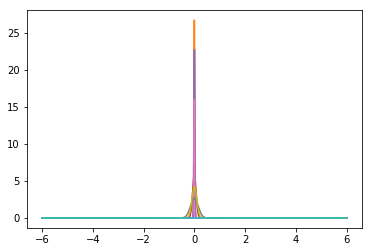

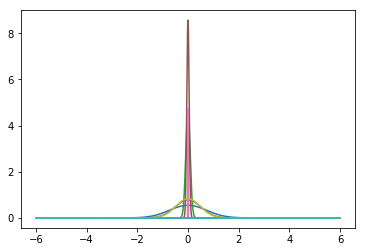

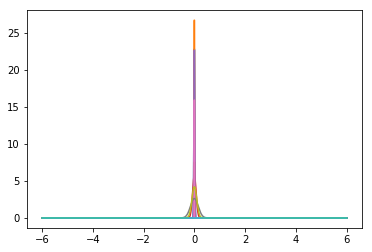

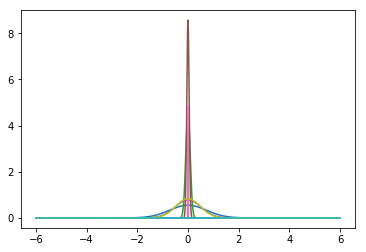

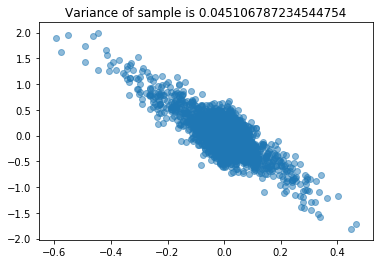

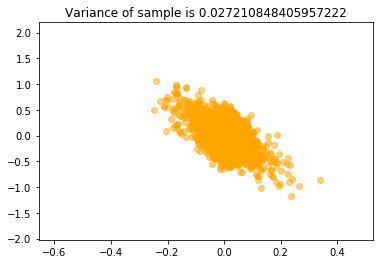

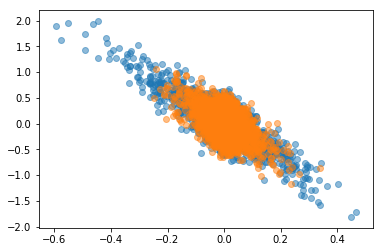

In [11]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

testmodel = centeredIndependentFactorAnalysisTest(n_observations=n_observations, **map_estimates)
#testmodel = centeredIndependentFactorAnalysisTest(n_observations=n_observations, mc_samples=1, **map_estimates)
ppc = sess.run(testmodel.distribution.sample())

plot_source_distributions(generated['mixture_component_var'],sess)
plot_source_distributions(map_estimates['mixture_component_var'],sess)

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(generated['data'].var()))
plt.scatter(*generated['data'].T,alpha=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(ppc.var()))
plt.scatter(*ppc.T, alpha=.5,c='orange')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

fig, ax = plt.subplots()
plt.scatter(*generated['data'].T,alpha=.5)
plt.scatter(*ppc.T, alpha=.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [12]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [13]:
sess.run(train_nll_init)

2.343139

In [14]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [15]:
generated_vars = generated.copy()
map_estimate_vars = sess.run(map_estimates)

In [16]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [17]:
sess.run(train_nll_true_model)

2.2804558

In [18]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

[0.00376463 0.1029786 ]
[0.00376464 0.10297862]


In [19]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

[[0.00043602 0.03720439]]
[[0.00043597 0.03720412]]


In [20]:
fgen = generated['factor_loadings']
fpred = map_estimate_vars['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

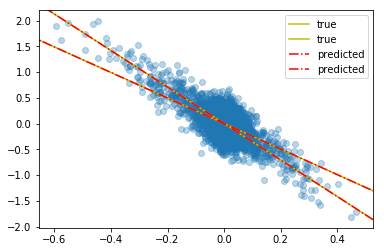

In [21]:
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



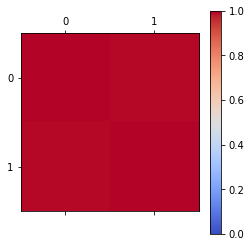

In [22]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [23]:
generated_vars

OrderedDict([('mixture_component_var',
              array([[2.6800693e-04, 1.2499795e-05, 3.6115280e-12, 4.8608179e-03,
                      2.7228479e-04, 5.8040282e-06, 8.3570139e-06, 2.3207216e-02,
                      9.0112472e-03, 8.4778549e-08],
                     [5.2795362e-01, 5.9347877e-07, 7.4767843e-03, 3.1528193e-13,
                      2.6155710e-01, 2.1346100e-03, 4.9654336e-06, 5.7286758e-08,
                      2.3065801e-01, 1.5495729e-07]], dtype=float32)),
             ('mixture_weights',
              array([[0.21315643, 0.00831374, 0.0008285 , 0.197122  , 0.12752934,
                      0.13037449, 0.0646439 , 0.11736472, 0.13490754, 0.00575922],
                     [0.05689703, 0.04521026, 0.12209526, 0.17767195, 0.00676397,
                      0.04458206, 0.13686676, 0.20522708, 0.07088348, 0.13380218]],
                    dtype=float32)),
             ('sources', array([[-0.19011185,  0.01029929],
                     [ 0.33053717,  0.0553787 ],

In [24]:
map_estimate_vars

{'mixture_component_var': array([[2.6806575e-04, 1.2516897e-05, 3.6115303e-12, 4.8608468e-03,
         2.7223694e-04, 5.8412379e-06, 8.3446157e-06, 2.3207244e-02,
         9.0111960e-03, 8.4778478e-08],
        [5.2795374e-01, 5.9347894e-07, 7.4767997e-03, 3.1527119e-13,
         2.6155713e-01, 2.1346656e-03, 5.0067774e-06, 5.7286794e-08,
         2.3065814e-01, 1.5495709e-07]], dtype=float32),
 'mixture_weights': array([[0.21315627, 0.00831374, 0.0008285 , 0.1971221 , 0.12752928,
         0.13037449, 0.06464391, 0.11736485, 0.13490762, 0.00575922],
        [0.05689703, 0.04521023, 0.12209516, 0.17767192, 0.00676397,
         0.04458205, 0.13686684, 0.20522721, 0.07088345, 0.13380216]],
       dtype=float32),
 'factor_loadings': array([[ 0.87070197, -2.1604466 ],
        [-0.36385584,  1.2907344 ]], dtype=float32),
 'data_var': array([[0.00043597, 0.03720412]], dtype=float32)}